In [47]:
#Folders of Ground truth Masks and Original Image Samples
masks = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\verge_masks\SegmentationClass"
samples = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\gv_seg"

In [48]:
#get sample 1
import os
samp1 = os.path.join(samples,os.listdir(samples)[0])
print(samp1)

C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\gv_seg\20220605231413_000097_Trim_frame2.jpg


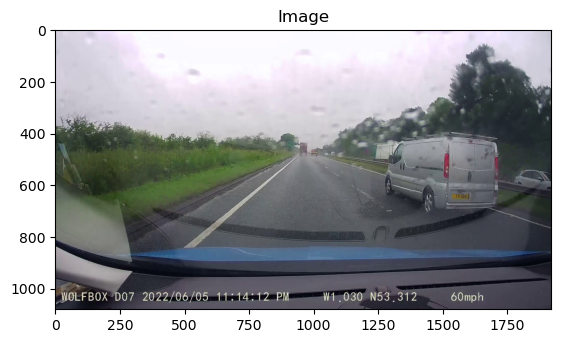

In [49]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread(samp1)
plt.title("Image")
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))


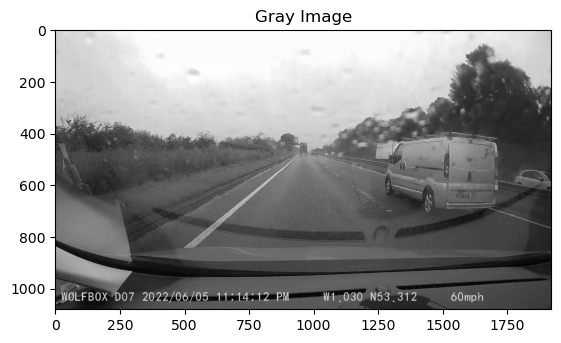

In [50]:
#greyscale
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.title("Gray Image")
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB),cmap = 'gray' )


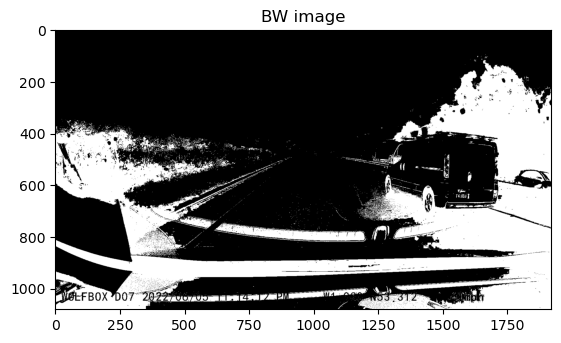

In [51]:
#otsu
#(thresh, im_bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

thresh = 75
im_bw = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]

#cv2.imshow('BW image', ~im_bw)
  
plt.title('BW image')
plt.imshow(cv2.cvtColor(~im_bw,cv2.COLOR_BGR2RGB),cmap = 'gray' )

In [52]:
#colourfixed
Sample_Fix = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

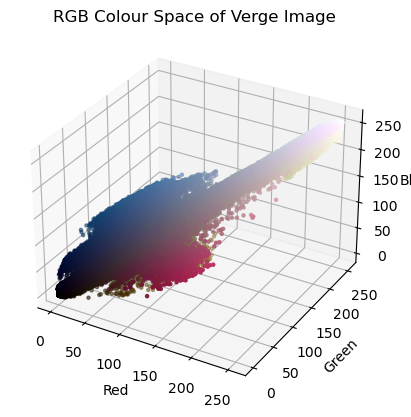

In [53]:
#Show Colour Space
#https://realpython.com/python-opencv-color-spaces/
#Takes a while
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import numpy as np
r, g, b = cv2.split(Sample_Fix)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = Sample_Fix.reshape((np.shape(Sample_Fix)[0]*np.shape(Sample_Fix)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.title("RGB Colour Space of Verge Image")
plt.show()

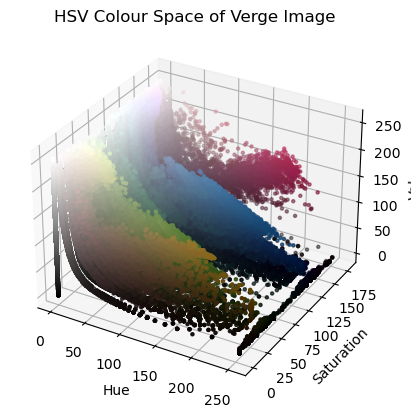

In [54]:
#Convert to HSV and show new colour space
hsv_dashcam = cv2.cvtColor(Sample_Fix, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_dashcam)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(s.flatten(),h.flatten(), v.flatten(),  facecolors=pixel_colors, marker=".")
axis.set_ylabel("Saturation")
axis.set_xlabel("Hue")
axis.set_zlabel("Value")
plt.title("HSV Colour Space of Verge Image")

plt.show()

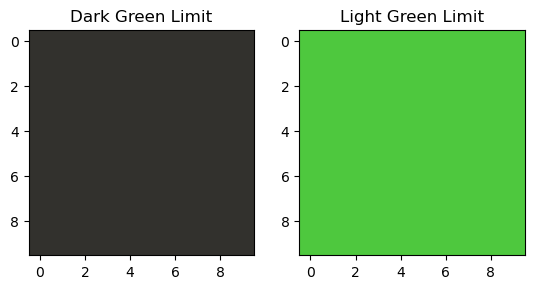

In [55]:
#Display Range
#https://stackoverflow.com/questions/47483951/how-to-define-a-threshold-value-to-detect-only-green-colour-objects-in-an-image
light_green = (80,175,200)
dark_green = (36,25,50)
from matplotlib.colors import hsv_to_rgb
lo_square = np.full((10, 10, 3), light_green, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_green, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.title("Dark Green Limit")
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.title("Light Green Limit")
plt.show()

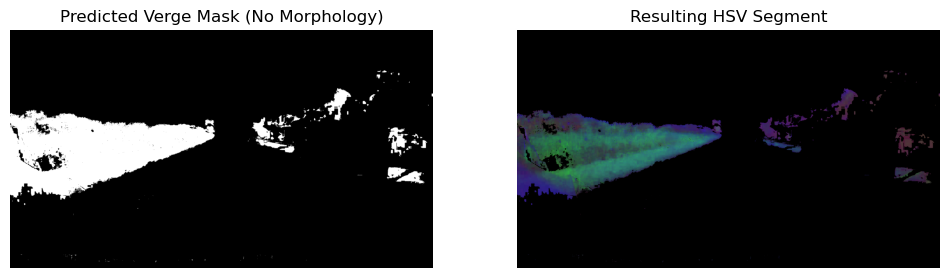

In [56]:
#Show Masked Colour Regions
plt.figure(figsize=(12, 7))

mask = cv2.inRange(hsv_dashcam, dark_green, light_green)
result = cv2.bitwise_and(hsv_dashcam, hsv_dashcam, mask=mask) # impose mask

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Predicted Verge Mask (No Morphology)")
plt.imshow(mask, cmap = 'gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Resulting HSV Segment")
plt.imshow(result)
plt.show()

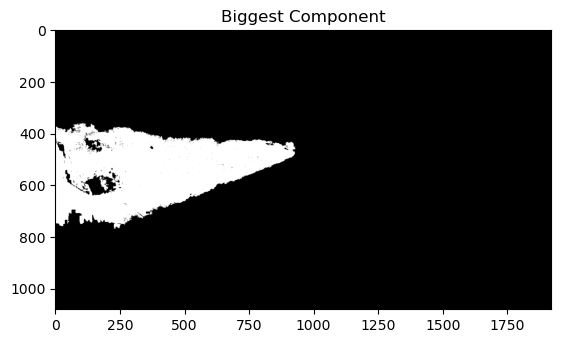

In [57]:
#Focus on largest verge
#https://stackoverflow.com/questions/47055771/how-to-extract-the-largest-connected-component-using-opencv-and-python
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)
sizes = stats[:, -1]

max_label = 1
max_size = sizes[1]
for i in range(2, nb_components):
    if sizes[i] > max_size:
        max_label = i
        max_size = sizes[i]

img2 = np.zeros(output.shape)
img2[output == max_label] = 255
plt.title("Biggest Component")
plt.imshow(img2, cmap="gray")

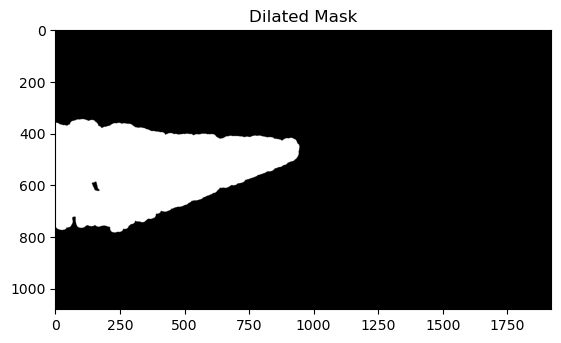

In [58]:
from skimage.morphology import disk
#dilate

# define the kernel
se = disk(15)
  
# closing the image
dilate = cv2.morphologyEx(img2, cv2.MORPH_DILATE, se, iterations=1)

plt.title("Dilated Mask")
plt.imshow(dilate,cmap="gray")

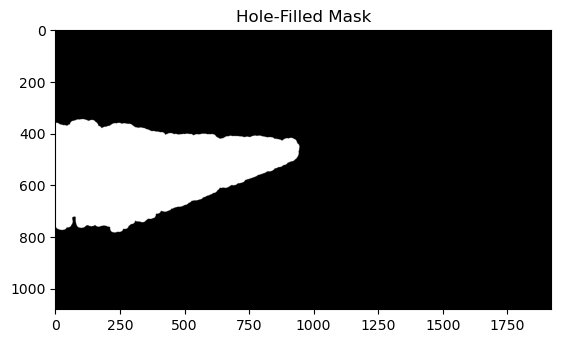

In [59]:
#fill holes
# Copy the thresholded image.
im_floodfill = (dilate.astype(np.uint8)).copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = dilate.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = dilate.astype(np.uint8) | im_floodfill_inv
 
# Display images.
plt.title("Hole-Filled Mask")
plt.imshow(cv2.cvtColor(im_out,cv2.COLOR_BGR2RGB))

#cv2.waitKey(0)

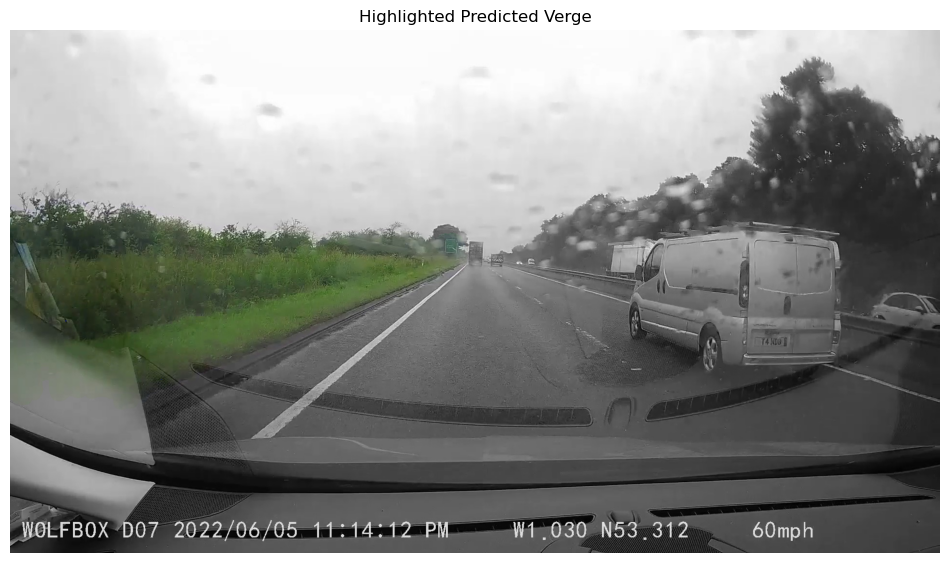

In [60]:
#Visualising Colour Mask
plt.figure(figsize=(12, 7))

rgb = cv2.cvtColor(im_out, cv2.COLOR_GRAY2BGR) # convert predicted verge mask to 3-channel space
green_mask = cv2.bitwise_and(rgb,im)

# cv2.imshow("Verge Mask", green_mask)
# cv2.waitKey(0)


gray_shell = cv2.bitwise_or(im_out,gray)# Cut out segment from full grey image

# cv2.imshow("Shell Mask", gray_shell)
# cv2.waitKey(0)

g_full = cv2.cvtColor(gray_shell, cv2.COLOR_GRAY2BGR) # convert grey template to 3-channel space
highlighted_image = green_mask + g_full # add rgb segment to gap in grey image

# Display Highlight.
plt.title("Highlighted Predicted Verge")
plt.axis('off')
plt.imshow(cv2.cvtColor(highlighted_image,cv2.COLOR_BGR2RGB), cmap="gray")


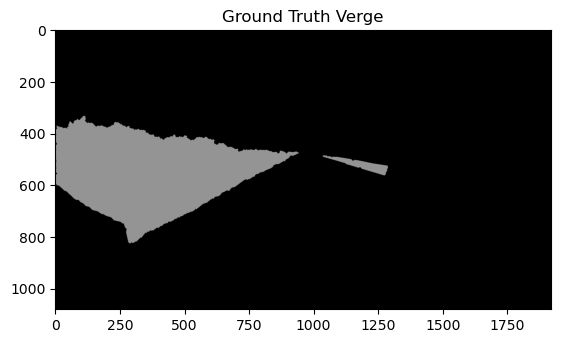

In [61]:
#get metrics & visualise all
gt_mask_p = os.path.join(masks,os.listdir(masks)[0])
gt_mask = cv2.imread(gt_mask_p)
gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
plt.title("Ground Truth Verge")
plt.imshow(cv2.cvtColor(gt_mask,cv2.COLOR_BGR2RGB))

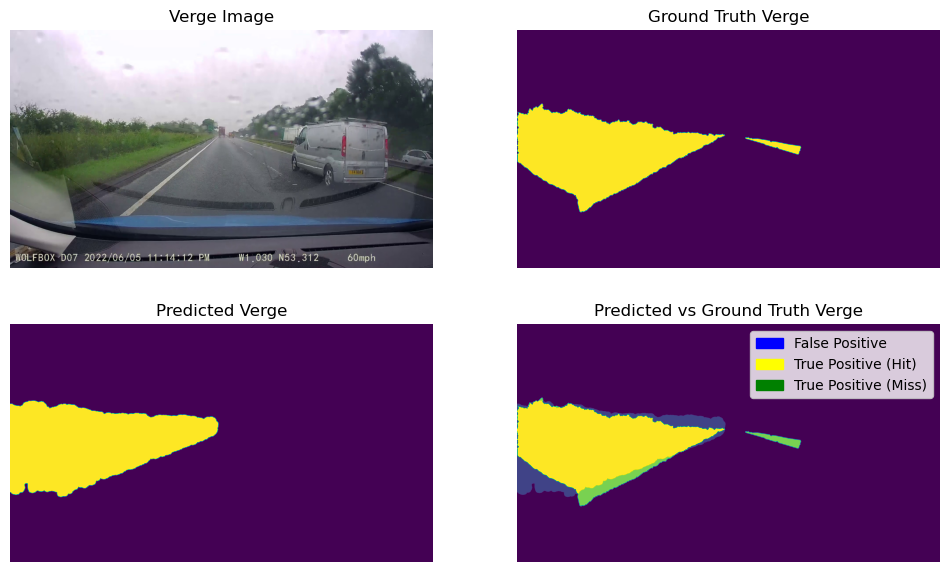

In [62]:
import matplotlib.patches as mpatches
#Visualise Differences
plt.figure(figsize=(12, 7))

#overlap images
(thresh, gt_bw) = cv2.threshold(gt_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)#convert mask to grayscale
src1 = im_out
src2 = gt_bw
alpha = 0.2
beta = (1.0 - alpha)
dst = cv2.addWeighted(src1, alpha, src2, beta, 0.0)

#Patch labels for comparison
blue_patch = mpatches.Patch(color='blue', label='False Positive')
yellow_patch = mpatches.Patch(color='yellow', label='True Positive (Hit)')
green_patch = mpatches.Patch(color='green', label='True Positive (Miss)')

#Ground Truth
plt.subplot(2,2,1)
plt.axis('off')
plt.title("Verge Image")
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))


#Ground Truth
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Ground Truth Verge")
plt.imshow(gt_bw)

#predicted
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Predicted Verge")
plt.imshow(im_out)

#predicted vs GT
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Predicted vs Ground Truth Verge")
plt.legend(handles=[blue_patch,yellow_patch,green_patch])
plt.imshow(dst)

In [63]:
#Get Metrics

#DICE
# segmentation
seg = im_out
# ground truth
gt = gt_bw

intersection = np.logical_and(seg, gt)
union = np.logical_or(seg, gt)

#DICE
dice = 2. * np.sum(intersection) / (np.sum(seg) + np.sum(gt))
#IOU
iou_score = np.sum(intersection) / np.sum(union)

In [64]:
#Now perform for all images

def hsv_segment(rgb_image,c_range1,c_range2):
    #convert to hsv
    hsv_dashcam = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    #get colour mask
    mask = cv2.inRange(hsv_dashcam, c_range1, c_range2)
    
    #Get Biggest Verge
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    big_v = np.zeros(output.shape)
    big_v[output == max_label] = 255
    
    #Close
    
    # define the kernel
    se = disk(10)

    # closing the image
    closing = cv2.morphologyEx(big_v, cv2.MORPH_CLOSE, se, iterations=1)
    
    # fill holes

    # Copy the thresholded image.
    im_floodfill = (closing.astype(np.uint8)).copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = closing.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = closing.astype(np.uint8) | im_floodfill_inv
    
    return im_out

def evaluate_segment(seg,gt,prnt = False):
    seg = np.asarray(seg).astype(np.bool)
    gt = np.asarray(gt).astype(np.bool)
    intersection = np.logical_and(seg, gt)
    union = np.logical_or(seg, gt)
    
    #DICE
    dice = 2. * np.sum(intersection) / (np.sum(seg) + np.sum(gt))

    #IOU

    iou_score = np.sum(intersection) / np.sum(union)
    if prnt == True:
        print('IoU similarity score is {}'.format(iou_score))
        print('Dice similarity score is {}'.format(dice))
    return dice, iou_score

def format_gt(gt_mask_im):
    gt_mask = cv2.cvtColor(gt_mask_im, cv2.COLOR_BGR2GRAY)
    (thresh, gt_bw) = cv2.threshold(gt_mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)#convert mask to grayscale
    return gt_bw


C:\Users\Computing\AppData\Local\Temp\ipykernel_10396\3766059751.py:55: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg = np.asarray(seg).astype(np.bool)
C:\Users\Computing\AppData\Local\Temp\ipykernel_10396\3766059751.py:56: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gt = np.asarray(gt).astype(np.bool)


IoU similarity score is 0.760161363696176
Dice similarity score is 0.8637405403558086


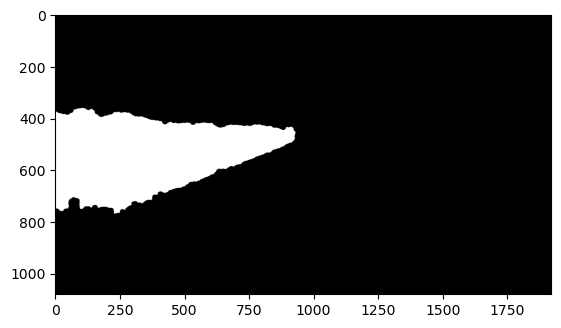

In [27]:
#Test Functions

light_green = (80,175,200)
dark_green = (36,25,50)

rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
test = hsv_segment(rgb, dark_green,light_green)
plt.imshow(test, cmap = "gray")

gt_mask_p = os.path.join(masks,os.listdir(masks)[0])
gt_mask = cv2.imread(gt_mask_p)
m = format_gt(gt_mask)

(dice, iou_score) = evaluate_segment(test,m, True)

In [28]:
from tqdm import tqdm
light_green = (80,175,200)
dark_green = (36,25,50)

#Perform over all dataset
samp_fs = os.listdir(samples)
mask_fs = os.listdir(masks)

ious = []
dices = []
for i in tqdm(range(0,len(samp_fs))):
    im_p = os.path.join(samples,samp_fs[i])
    gt_name = samp_fs[i].replace(".jpg",".png")
#     print(gt_name)
    gt_p = os.path.join(masks,gt_name)
    
    im = cv2.imread(im_p)
    #format full image
    rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    hsv = hsv_segment(rgb, dark_green,light_green)
    
    #format mask
    gt_mask = cv2.imread(gt_p)
    m = format_gt(gt_mask)

    (dice, iou_score) = evaluate_segment(hsv,m)
    

        
    ious.append(iou_score)
    dices.append(dice)
    
print("Average IOU: ", np.mean(ious))
print("Average Dice: ", np.mean(dices))

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\Computing\AppData\Local\Temp\ipykernel_10396\3766059751.py:55: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg = np.asarray(seg).astype(np.bool)
C:\Users\Computing\AppData\Local\Temp\ipykernel_10396\3766059751.py:56: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

Average IOU:  0.17522770682421962
Average Dice:  0.2601994281065947


<BarContainer object of 40 artists>

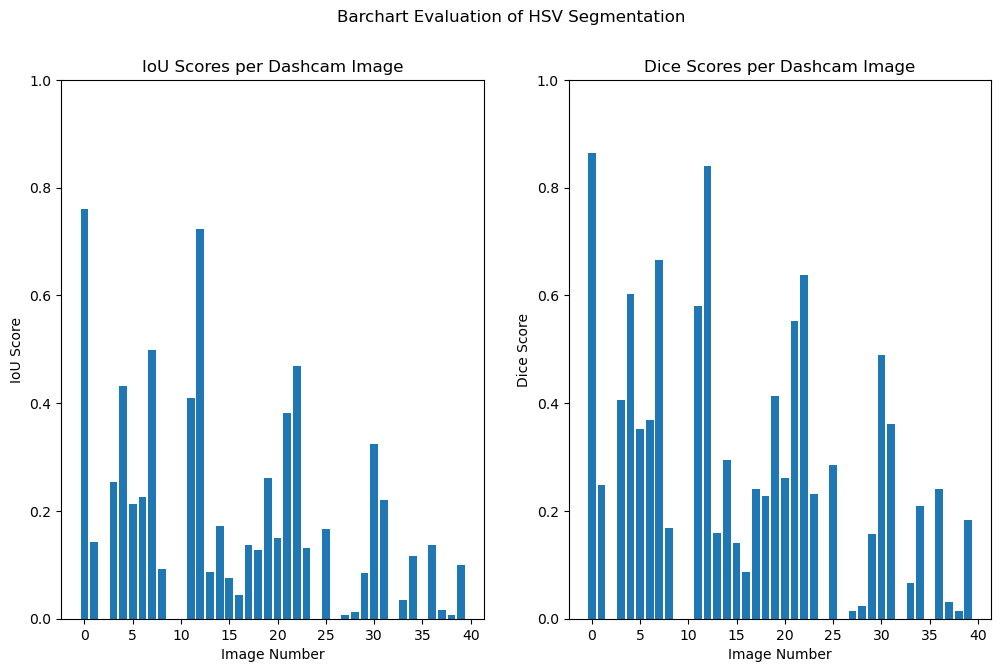

In [71]:
plt.figure(figsize=(12, 7))
plt.suptitle("Barchart Evaluation of HSV Segmentation")
h = range(0,len(ious))
plt.subplot(1,2,1)
plt.title("IoU Scores per Dashcam Image")
plt.xlabel("Image Number")
plt.ylabel("IoU Score")
plt.ylim(0,1)
plt.bar(h,ious)

plt.subplot(1,2,2)
plt.title("Dice Scores per Dashcam Image")
plt.xlabel("Image Number")
plt.ylabel("Dice Score")
plt.ylim(0,1)
plt.bar(h,dices)

In [72]:
#Show Images where IoU is at a certain condition
import operator


def visualizeImageIOU(op, amount, figL):
    plt.figure(figsize=(10, figL))
    
    #recognise operator input
    ops = {'>': operator.gt,
               '<': operator.lt,
               '>=': operator.ge,
               '<=': operator.le,
               '==': operator.eq}
    

    n_dices = []
    indexs = []

    #find indexes
    for i, u in enumerate(ious):
        if ops[op](u,amount):
            indexs.append(i)

    pic_indexer = 1

    #Print their ground truth masks and relevant images
    for i in range(0,len(indexs)):
        im_p = os.path.join(samples,samp_fs[indexs[i]])
        gt_name = samp_fs[indexs[i]].replace(".jpg",".png")
        gt_p = os.path.join(masks,gt_name)

        im = cv2.imread(im_p)
        #format full image
        rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        hsv = hsv_segment(rgb, dark_green,light_green)

        #format mask
        gt_mask = cv2.imread(gt_p)
        m = format_gt(gt_mask)

        plt.subplot(len(indexs),3,pic_indexer)
        plt.axis('off')
        plt.title(f"Image {indexs[i]}")
        plt.imshow(rgb)

        pic_indexer+=1

        plt.subplot(len(indexs),3,pic_indexer)
        plt.axis('off')
        plt.title("Ground Truth Verge")
        plt.imshow(m,cmap = "gray")

        pic_indexer+=1

        plt.subplot(len(indexs),3,pic_indexer)
        plt.axis('off')
        plt.title("Predicted Verge")
        plt.imshow(hsv,cmap = "gray")

        pic_indexer+=1

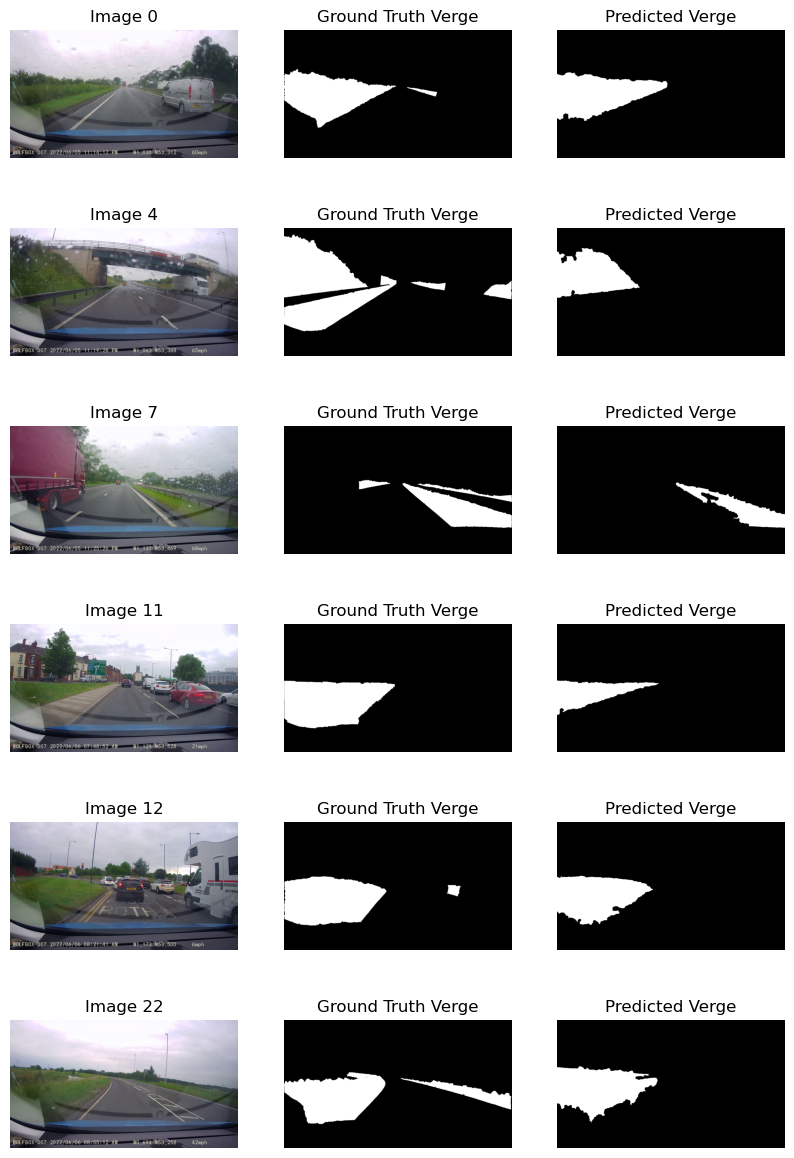

In [74]:
#Show Images where IoU is over 0.4 (Best)
visualizeImageIOU('>',0.4,15)

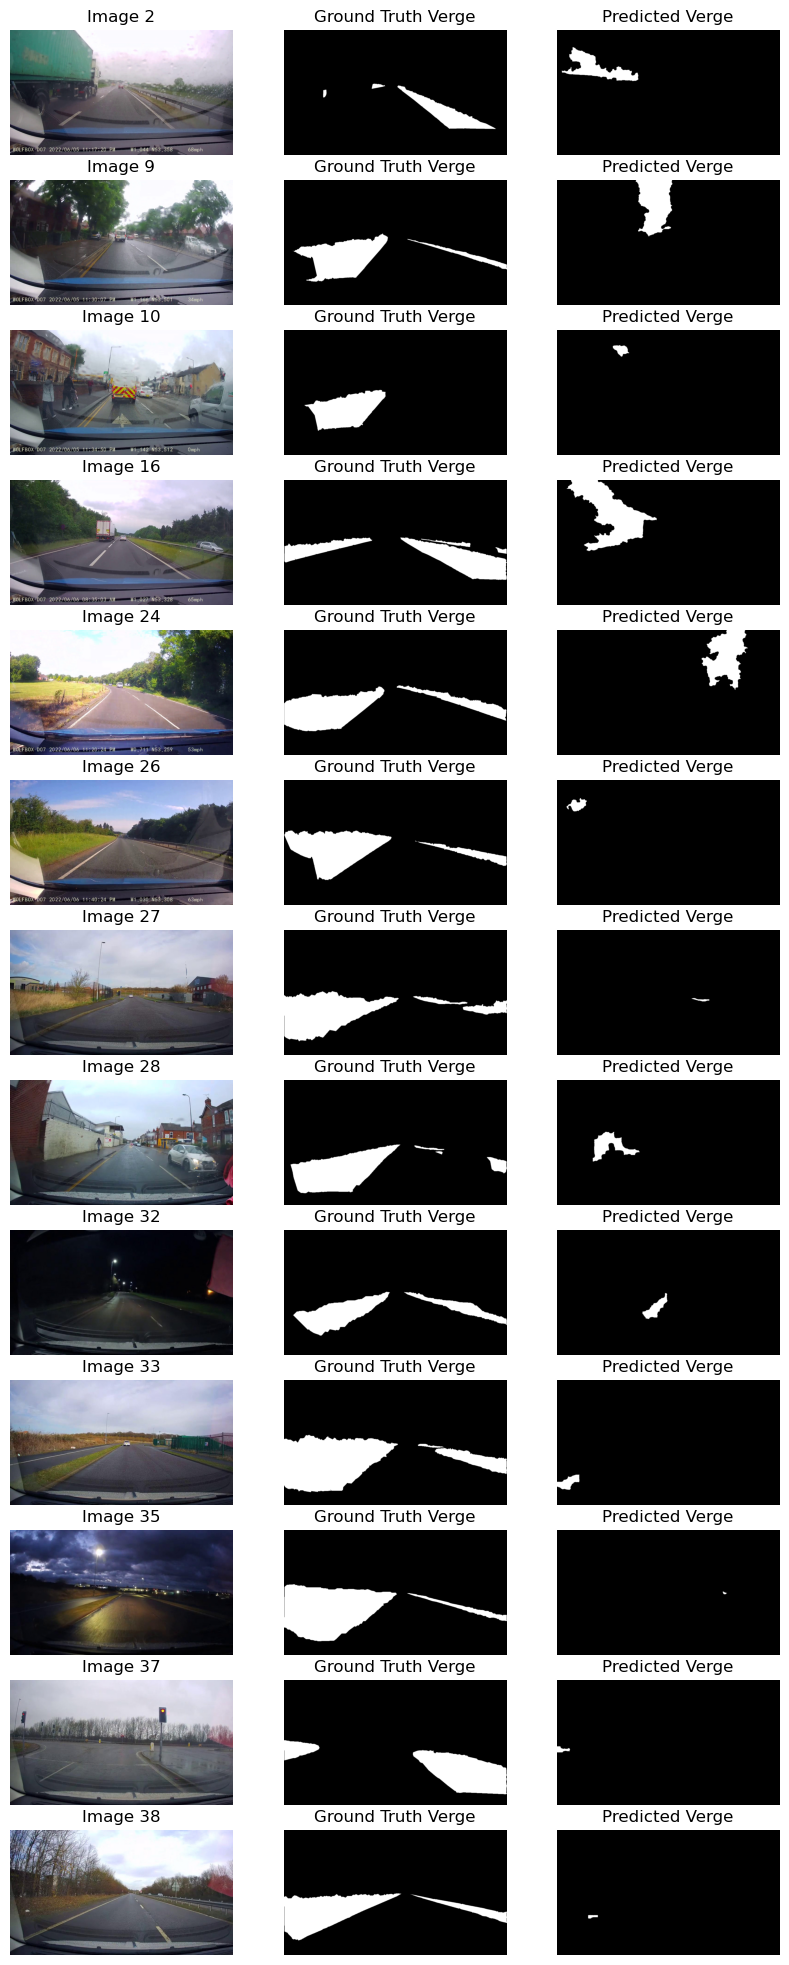

In [75]:
visualizeImageIOU('<',0.05,25)